# Разбор ДЗ4
Вариант 2. (сложный)
    1. реализовать нейронную сеть в схеме AlexNet на сifar10.
    2. оценить рост точности при увеличении ширины сети (больше ядер)
    3. оценить рост точности при увеличении глубины сети (больше слоев)


In [ ]:
# The full neural network code!
###############################
import numpy as np
import pandas as pd
#import mnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10





Можно обрабатывать данные - это улучшит результат. 



In [ ]:
(train_images,train_labels),(test_images,test_labels)=cifar10.load_data()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.


train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
#

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
from tensorflow.keras.models import Model 

## AlexNet

https://habr.com/ru/company/nix/blog/430524/


Использование блоков линейной ректификации (ReLU) в качестве нелинейностей.

Использование методики отбрасывания для выборочного игнорирования отдельных нейронов в ходе обучения, что позволяет избежать переобучения модели.

Перекрытие max pooling, что позволяет избежать эффектов усреднения average pooling.

In [ ]:
# соберу генерацию модели в функцию
def neuron_net(layerList = [8,16,32,64,128], kernel_size_=[5,3,3,3,3]):
  # Используеv функциональное API
  # первый слой всегда 32х32х3 входов
  
  # в передаваемых параметрах :layerList = [8,16,32,64,128] - число ядер по слоям, в kernel_size_=[5,3,3,3,3] - размеры ядер по слоям
  # инициализация  модели
  input1= tensorflow.keras.layers.Input(shape=(32,32,3))
  # первый сверточный слой
  x1 = tensorflow.keras.layers.Conv2D(layerList[0], kernel_size=(kernel_size_[0], kernel_size_[0]), strides=(1, 1), activation='relu',  padding="same")(input1)
  # второй пуллинговый слой
  x2 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x1)

  # третий сверточный слой
  x3 = tensorflow.keras.layers.Conv2D(layerList[1], kernel_size=(kernel_size_[1], kernel_size_[1]), strides=(1, 1), activation='relu', padding='same')(x2)

  # четвертый пуллинговый слой
  x4 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x3)

  # пятый блок  слоев свертки без изменения размеров
  x5 = tensorflow.keras.layers.Conv2D(layerList[2], kernel_size=(kernel_size_[2], kernel_size_[2]), strides=(1, 1), activation='relu', padding='same')(x4)
  x5 = tensorflow.keras.layers.Conv2D(layerList[3], kernel_size=(kernel_size_[3], kernel_size_[3]), strides=(1, 1), activation='relu', padding='same')(x5)
  x5 = tensorflow.keras.layers.Conv2D(layerList[4], kernel_size=(kernel_size_[4], kernel_size_[4]), strides=(1, 1), activation='relu', padding='same')(x5)
  x5 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x5)

  # векторизирую CNN выход, чтобы можно было его присоединить к полносвязногому слою
  x6 = tensorflow.keras.layers.Flatten()(x5)

  # шестой полносвязный слой
  x7 = tensorflow.keras.layers.Dense(84, activation='relu')(x6)

  # выходной слой с функцией активации softmax
  out_x = tensorflow.keras.layers.Dense(10, activation='softmax')(x7)

  model = Model(inputs = input1, outputs = out_x)
  model3 = Model(inputs = input1, outputs = x3) # эТО ДЛЯ ПОСМОТРЕТЬ ВНУТРИ
  model5 = Model(inputs = input1, outputs = x5)  # эТО ДЛЯ ПОСМОТРЕТЬ ВНУТРИ
# компилияция модели
  model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

  return model, model3,model5

In [ ]:
### Эксперимент
epochs = 100
Error_exp_ = pd.DataFrame(data=np.array([[0,0,0,0,0]]),columns = ['neuron','batch_size','epoch','error','accuracy'])
ik=0
for neuron_ in [64,128]:
  # меняю число нейронов скрытого слоя
  #print(neuron_)
  for batch_size_ in [50, 100,200]:
    # меняю размер пакета для обучения
    eerors = []
    acc =[]
    for j in range(3):
      # будем делать несколько перезапусков - сейчас 3
      
      # создаем сеть
      model, model3,model5 = neuron_net(layerList = [neuron_,16,32,64,128],kernel_size_=[5,3,3,3,3])
      # учим сеть и проверяем сразу, т.к. включаю validation_split=0.2
      history = model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
      # записываю результаты валидации, а не обучения - это честно
      eerors.append(history.history['val_loss'][-1])
      acc.append(history.history['val_accuracy'][-1])
    # Табличка !!!! 
    Error_exp_.loc[ik,['neuron','batch_size','epoch','error','accuracy']] = [neuron_,batch_size_,epochs ,np.mean(eerors),np.mean(acc)]
    ik +=1


# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]

[5 1 0 8 6]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
# Покажем нашУ модельку
model.summary()

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 32, 32, 16)        18448     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 16, 64)        184

In [ ]:
# табличка !!!!
Error_exp_

,neuron,batch_size,epoch,error,accuracy
0,64.0,50.0,100.0,1.067934,0.625967
1,64.0,100.0,100.0,1.088103,0.617667
2,64.0,200.0,100.0,1.061037,0.626800
3,128.0,50.0,100.0,1.064574,0.620567
4,128.0,100.0,100.0,1.058547,0.623900
5,128.0,200.0,100.0,1.086864,0.615167


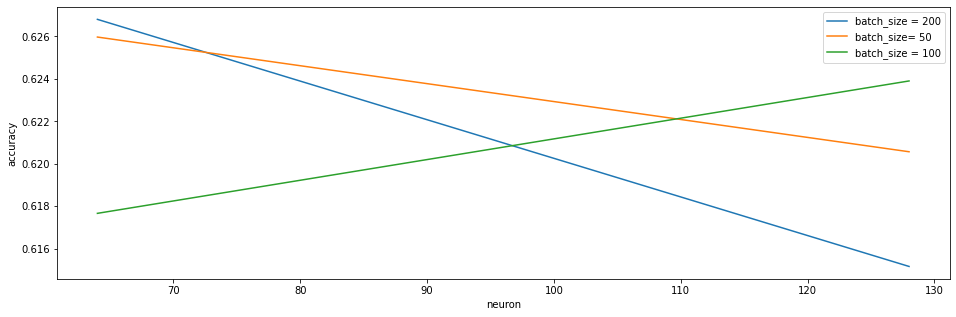

In [ ]:
import matplotlib.pyplot as plt

# ГРАФИКИ !!!!! - это будет точность от числа нейронов по размерам пакетов(batch_size)
e1 = Error_exp_.loc[Error_exp_['batch_size']==200,['neuron','accuracy']]
e2 = Error_exp_.loc[Error_exp_['batch_size']==50,['neuron','accuracy']]
e3 = Error_exp_.loc[Error_exp_['batch_size']==100,['neuron','accuracy']]
plt.figure(figsize=(16,5))

plt.xlabel('neuron')
plt.ylabel('accuracy')
plt.plot(e1['neuron'],e1['accuracy'],label = 'batch_size = 200')
plt.plot(e2['neuron'],e2['accuracy'],label = 'batch_size= 50')
plt.plot(e3['neuron'],e3['accuracy'],label = 'batch_size = 100')
plt.legend()
plt.show()

# Анализ сводной таблицы и графики :

 - Нужно сделать больше экспериментов и посмотреть на конструкцию модели еще как-то :) 


# Рекомендации:
Строим цикл для изменения размера ядер и их числа
Строим цикл для изменения число слоев - нужно перерабатывать модель  в автоматом заполняемую (свертки блока 5 можно автоматизировать)
Первый полносвязный слой - нужно переопределить число нейронов и посмотреть на широком эксперименте, что получится


нейронки работают от случайной начальной точки - делаем много перезапусков (больше 3) для анализа архитектуры и осредняем результаты

нейронки работают от случайной начальной точки - делаем много перезапусков дляпоиска лучшего варианта, если делаем обучение для работы

Делаем таблички и графики

Проводим анализ результатов: оцениваем средние ошибки(точности) архитектур и дисперсии ошибок (точности) - потом делаем выводы!!

Для этой задачи можно проверить влияние размера выборки, включать/выключать нормализацию данных, проверить поведение по числу эпох, изменять параметры оптимизатора, брать разные активации, разное число слоев, разный loss и т.п.